In [1]:
import time 
import pandas as pd 
import sys 
import numpy as np
import matplotlib.pyplot as plt
import io
import diffprivlib.models as dp

sys.path.append('DataSynthesizer/')
from DataDescriber import DataDescriber
from DataGenerator import DataGenerator
from ModelInspector import ModelInspector
from sklearn.datasets import make_classification, make_blobs
from sklearn.linear_model import LogisticRegression
from utils.utils import * 
from lib.utils import read_json_file
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from tqdm import tqdm, trange 

# Differentially private synthetic data generation 

Helper functions:  

In [ ]:
def plot_results(n_range, times, network_params, saveas=None):
    """
    Plot timing results of synthetic data generation process
    """
    for index, (eps, k) in enumerate(network_params):
        plt.plot(n_range, times[index], label='eps='+str(eps)+', k='+str(k))

    plt.legend()
    plt.ylabel('Time (seconds)')
    plt.title('Time to generate synthetic data')
    plt.xlabel('Multiplicity of synthetic dataset compared to actual')
    if not saveas: 
        saveas = '../output/time_plot.jpg'
    plt.savefig(saveas)
    plt.show()


def create_synth_data(
    dataset, 
    description_path, 
    n,
    eps=0, 
    max_degree=2, 
    datatypes=None,
    categories=None,
    candidate_keys=None,
    out_path='../output/synthetic.csv',
    opt=False
    ):
   
    if not opt:  
        # Suppress output 
        save_stdout = sys.stdout
        sys.stdout = io.StringIO()

    # Step 1: Describe data 
    print('Describing data...\n')
    describe_data(
        dataset, 
        description_path, 
        eps=eps, 
        max_degree=max_degree,
        datatypes=datatypes,
        categories=categories,
        candidate_keys=candidate_keys,
        )

    # Step 2: Generate data 
    print('Generating data, n =', n, '\n')
    generate_data(description_path, n, out_path)

    if not opt: 
        # Reset standard output
        sys.stdout = save_stdout


def generate_data(description_path, n, out_path):
    """
    Generate synthetic data described by description_path. 

    :param n: number data points to generate
    :param out_path: where to save dataset
    """
    generator = DataGenerator()
    generator.generate_dataset_in_correlated_attribute_mode(n, description_path)
    generator.save_synthetic_data(out_path)


def describe_data(
    dataset, 
    description_path, 
    eps=0, 
    max_degree=2,
    datatypes=None, 
    categories=None,
    candidate_keys=None,
    ):
    """
    Contruct a json description of the data, which is later used in generation
    phase. 
    
    :param dataset: dataset in csv format
    :param description_path: Save path for description (should be a json file)
    :param attribute_to_datatype: dictionary of features and their type 
    :param attribute_to_is_categorical: T/F dictionary of whether features are categorical 
    :param eps: differential privacy setting 
    :param k: Maximum number of neighbouring nodes in Bayesian network
    """
    describer = DataDescriber() 
    describer.describe_dataset_in_correlated_attribute_mode(
        dataset_file=dataset,
        epsilon=eps,
        k=max_degree,
        attribute_to_datatype=datatypes, 
        attribute_to_is_candidate_key=candidate_keys,
        attribute_to_is_categorical=categories)

    # Save description as json 
    describer.save_dataset_description_to_file(description_path)


def plot_clf_data(X, ax=None):
    """ Plot two dimensional classification data. 
    Assign figure to ax if supplied"""
    y = X[:,2]
    for i in range(2):
        if ax is not None: 
            ax.scatter(X[y==i][:,0], X[y==i][:,1], marker='o')
        else: 
            plt.scatter(X[y==i][:,0], X[y==i][:,1], marker='o')

    return ax 
    
        

def regr_line(X, y, z):
    """
    Fit logistic regression to X and y and return 
    the decision boundary line along values of z
    """
    clf = LogisticRegression(solver='lbfgs')
    clf.fit(X,y)

    w = clf.coef_[0]
    b = clf.intercept_

    return - (w[0] * z + b ) / w[1]

    
def gen_seed_data(n, d, scale=1, gauss=False): 
    """
    Generates random classification data using sklearn's 
    make_classification. 

    If gauss == True, use make_blobs to generate data which 
    is normally distributed. 
    
    :param n, d: Rows, featurs
    :return X: n x (d+1) matrix, last row contains labels
    """
    if gauss: 
        X, y = make_blobs(
            n_samples=n, 
            n_features=d)
        X = X * scale
    else: 
        X, y = make_classification(
            n_samples=n, 
            n_features=d, 
            n_informative=d, 
            n_redundant=0, 
            class_sep=1,
            n_clusters_per_class=1,
            scale=scale
        )
        
    return np.insert(X,d,y,axis=1)



def synth_setup(X, dataset_file, preset_types=None, preset_categories=None, preset_keys=None):
    """
    Runs necessary setup to generate synthetic data from X. 

    - Writes X to dataset_file in csv format 
    - Feature labels are f1, ..., fd where d is number of columns in X. 
    - Construct datatypes, categories, and cand_keys dictionaries. 
    - By default, all datatypes are float, all features are not
    categorical except the last one, and all features are not  
    candidate keys. 
    - If preset_<> is present, sets feature number i to whatever value has 
    key i in relevant dict. 

    """

    d = len(X[0,:])
    
    # Setup dataframe 
    feature_labels = ['f'+str(i+1) for i in range(d)]
    pd.DataFrame(X, columns=feature_labels).to_csv(dataset_file, index=None)

    # Dictionary of datatypes, whether features are categorical, 
    # and weather keys are candidate keys. 
    datatypes, categories, cand_keys = {}, {}, {}
    
    preset_types_arr  = list(preset_types.keys()) if preset_types is not None else []
    preset_cat_arr    = list(preset_categories.keys()) if preset_categories is not None else []
    preset_keys_arr   = list(preset_keys.keys()) if preset_keys is not None else []

    for i in range(d):
        if i in preset_types_arr:
            datatypes[feature_labels[i]] = preset_types[i]
        else: 
            datatypes[feature_labels[i]] = 'Float'
        if i in preset_cat_arr: 
            categories[feature_labels[i]] = preset_categories[i]
        elif i == d-1: 
            categories[feature_labels[i]] = True 
        else: 
            categories[feature_labels[i]] = False 
        if i in preset_keys_arr: 
            cand_keys[feature_labels[i]] = preset_keys[i]
        else: 
            cand_keys[feature_labels[i]] = False 
    
    return datatypes, categories, cand_keys 
   

def setup_and_generate(X, n, eps=0, seed_data='../data/seed.csv', out_path='../data/synth.csv', 
                       desc='../data/description.csv', preset_categories=None, preset_types=None, 
                      preset_keys=None, max_degree=2, opt=False):
    """
    Run synth_setup and create_synth_data 
    """
    
    datatypes, categories, cand_keys = synth_setup(X, seed_data, preset_categories=preset_categories, 
                                                  preset_keys=preset_keys, preset_types=preset_types)
    
    create_synth_data(seed_data, desc, n, eps=eps, max_degree=max_degree, datatypes=datatypes, 
                     categories=categories, candidate_keys=cand_keys, opt=opt, out_path=out_path)

def heatmap(seed_data='../data/seed.csv', synth_data='../data/synth.csv', desc='../data/description.csv'):
    """
    Generate heatmap comparing correlations in seed data and synthetic data 
    """
    seed_df = pd.read_csv(seed_data)
    synth_df = pd.read_csv(synth_data)

    attribute_description = read_json_file(desc)['attribute_description']
    inspector = ModelInspector(seed_df, synth_df, attribute_description)
    inspector.mutual_information_heatmap()
    





## Correlation between attributes 
We can see that the synthetic data generation, when differential privacy is turned off, does a good job
of mimicking the correlations among the variables: 

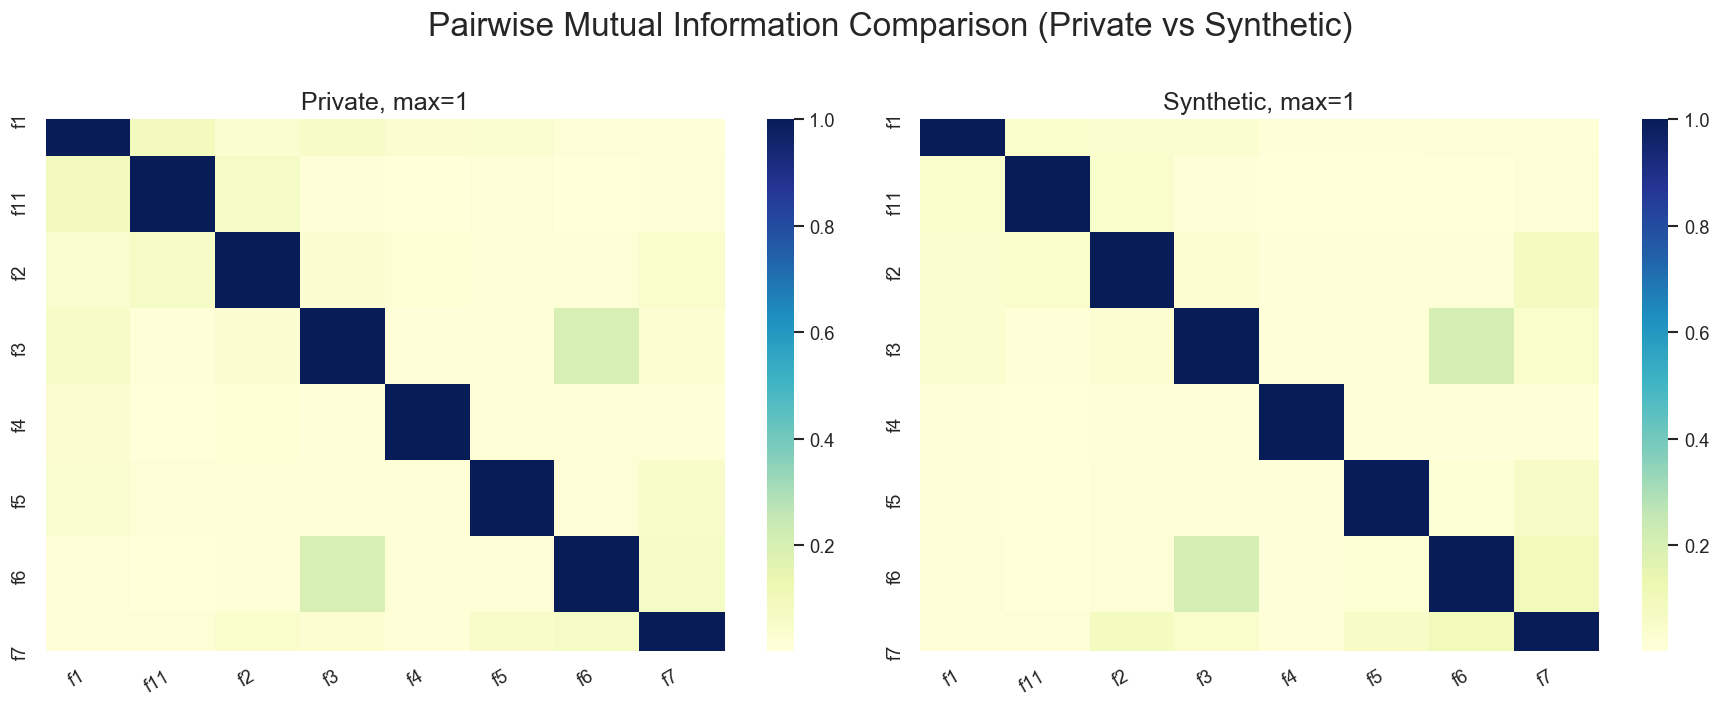

In [36]:
n, d = 5000, 10

# Generate random seed data using sklearn 
X = gen_seed_data(n, d)

# Make many of the features categorical 
preset_categories = {}
for i in range(d-3):
    X[:,i] = np.array(list(map(round, X[:,i])))
    preset_categories[i] = True 
    
# Generate synthetic data, epsilon = 0 
setup_and_generate(X, n, preset_categories=preset_categories)

# Generate heatmap 
heatmap()


### How does this change if we introduce $\epsilon$?
The lower the epsilon, the more private (except for $\epsilon=0$, which turns off differential privacy). 

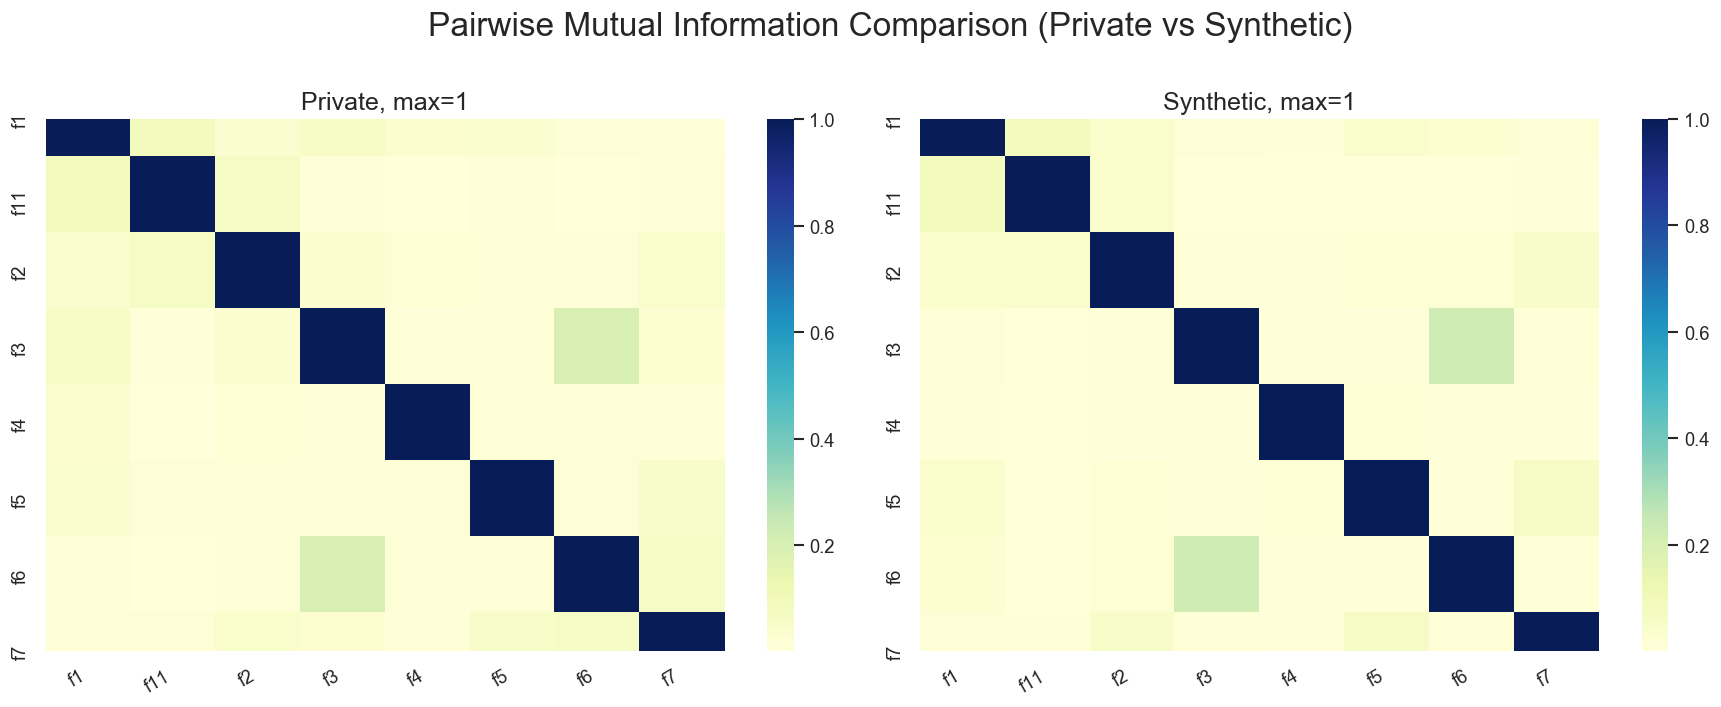

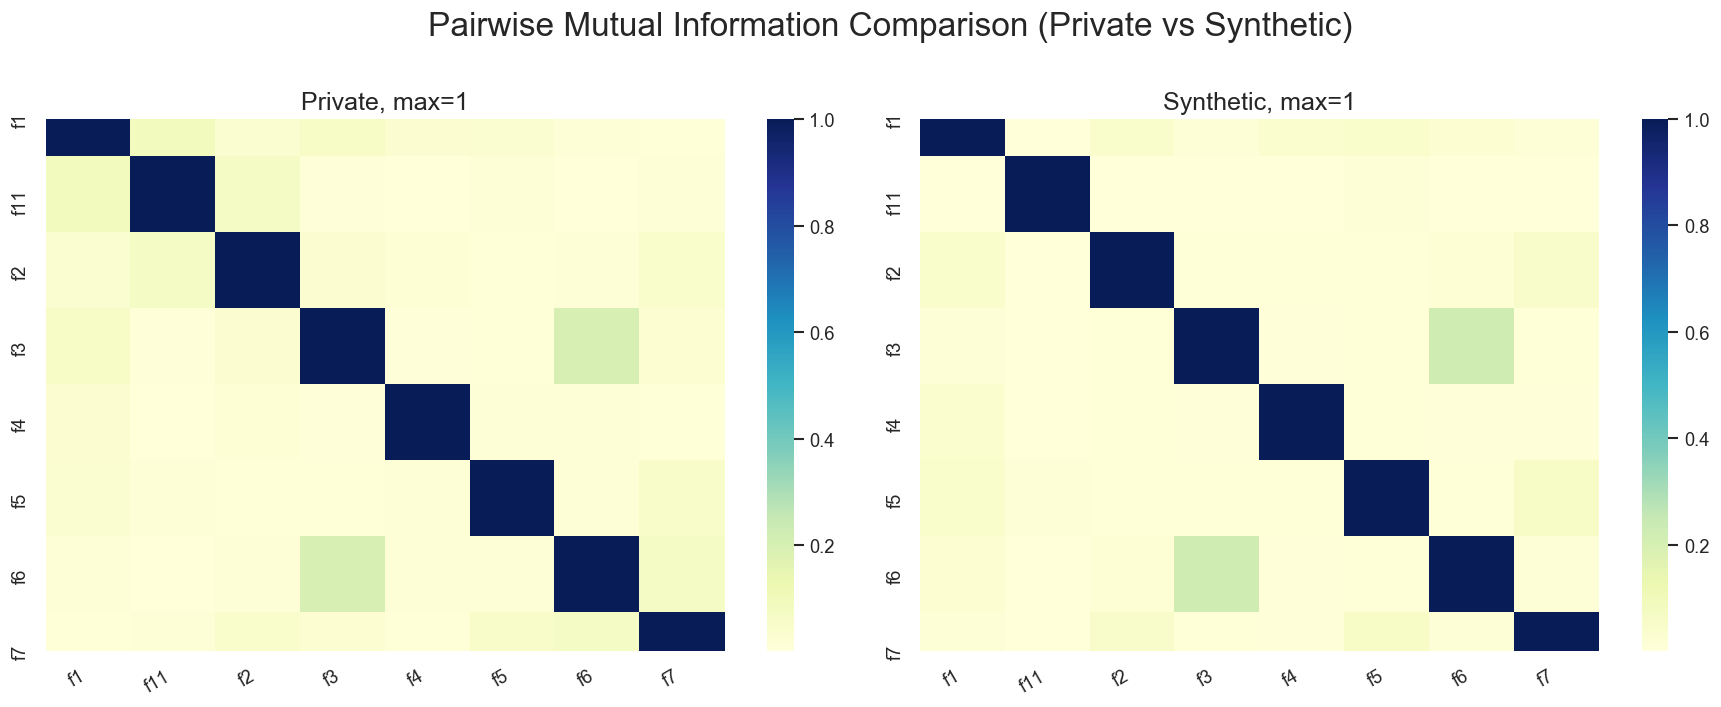

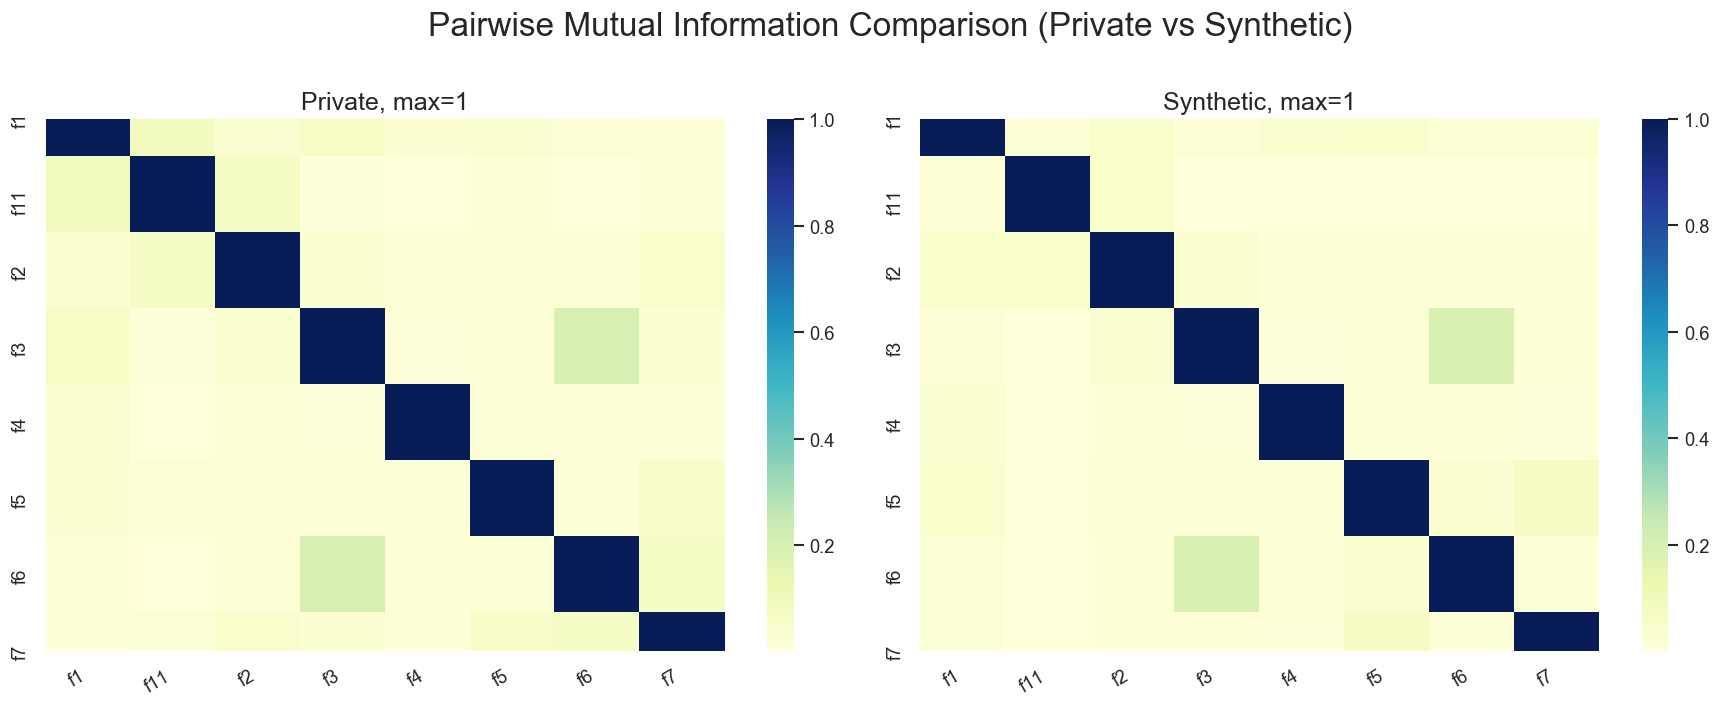

In [38]:

epsilons = [1, 0.5, 0.1]

for eps in epsilons: 
    setup_and_generate(X, n, eps=eps, preset_categories=preset_categories)
    heatmap()


### Looks about the same. Next let's see how candidate keys are treated. 

If we make the first four features candidate keys, they aren't included in the Bayesian network
and therefore don't show up in the heatmap. 

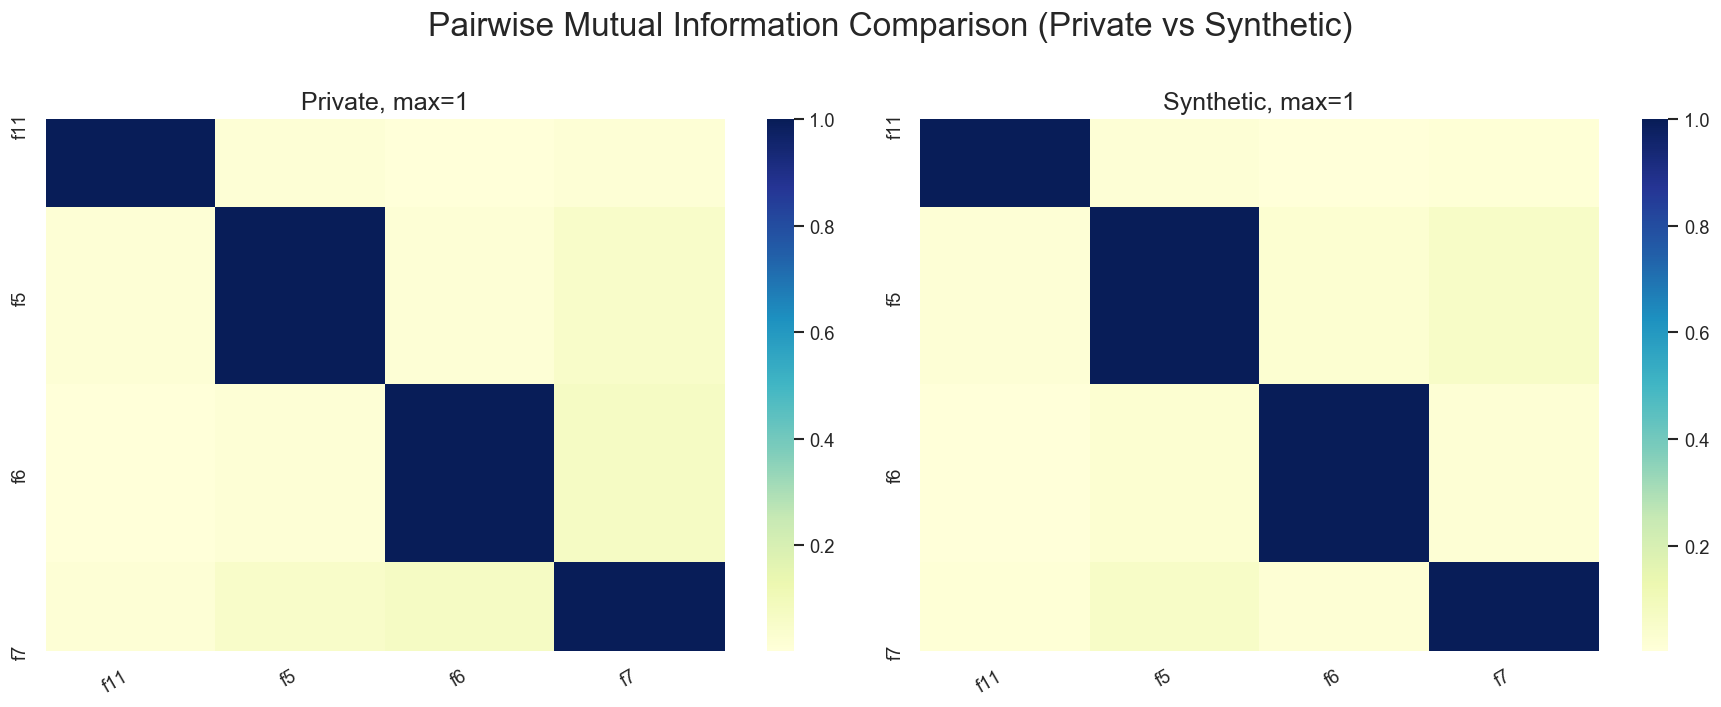

In [42]:
candidate_keys = {}
for i in range(4):
    candidate_keys[i] = True 
    
setup_and_generate(X, n, eps=0.1, preset_categories=preset_categories, preset_keys=candidate_keys)
heatmap()

    


### What's happening to the candidate keys?


In [55]:
candidate_keys = { 0: True, d-1: True }
setup_and_generate(X, n, eps=0.1, preset_categories=preset_categories, preset_keys=candidate_keys)


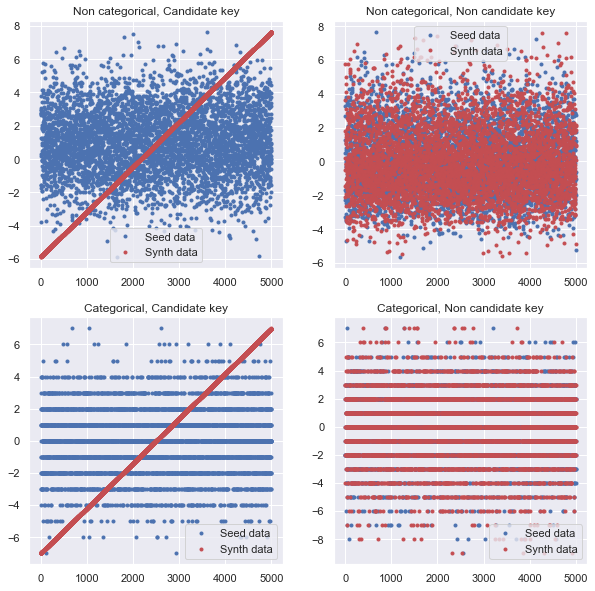

In [56]:
def plot_synth_vs_true(X, index, title, synth_data='data/synth.csv'):
    f1 = X[:,index]
    plt.plot(f1, '.', label='Seed data')
    f1_synth = pd.read_csv(synth_data).to_numpy()[:,index]
    plt.plot(f1_synth, 'r.', label='Synth data')
    plt.legend()
    plt.title(title)


plt.subplots(2, 2, figsize=(10,10))

plt.subplot(221)
plot_synth_vs_true(X, d-1, 'Non categorical, Candidate key')

plt.subplot(222)
plot_synth_vs_true(X, d-2, 'Non categorical, Non candidate key')

plt.subplot(223)
plot_synth_vs_true(X, 0, 'Categorical, Candidate key')

plt.subplot(224)
plot_synth_vs_true(X, 1, 'Categorical, Non candidate key')





## 2D Visualization

In [2]:
def plot_2d_boundary(X):
    """ Plot 2d classification data given by X and 
    corresponding decision boundary. 
    """
    
    # Plot generated data
    plot_clf_data(X)

    # Run logistic regression and plot decision boundary
    lims = (int(np.rint(np.min(X))), int(np.rint(np.max(X))))
    z = range(lims[0], lims[1])

    plt.plot(z, regr_line(X[:,:-1],X[:,-1],z), 'k', linewidth=3, label='Dec. Bound.')
    plt.ylim(lims)
    plt.xlim(lims)
    plt.legend()
    plt.show()
    

### Generate some random 2d seed data 

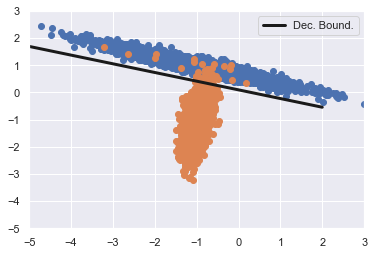

In [3]:
n, d = 5000, 2
X = gen_seed_data(n, d)

plot_2d_boundary(X)

### From this, generate synthetic data with no differential privacy:  

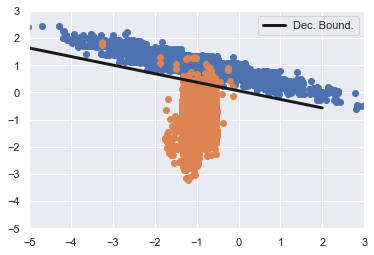

In [4]:
setup_and_generate(X, n, eps=0) 
X_synth = pd.read_csv('../data/synth.csv').to_numpy()

plot_2d_boundary(X_synth)

### What about strong differential privacy? $\epsilon=0.1$: 

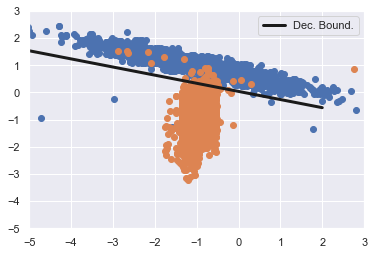

In [5]:
setup_and_generate(X, n, eps=0.1) 
X_synth = pd.read_csv('../data/synth.csv').to_numpy()

plot_2d_boundary(X_synth)

Again, there are no candidate keys, so it matches the seed distribution. 
If we make the first feature a candidate key, however, then the distribution
is obscured.

Somewhat disturbingly, however, the value of $\epsilon$ doesn't seem to affect the 
level of noise very significantly. 

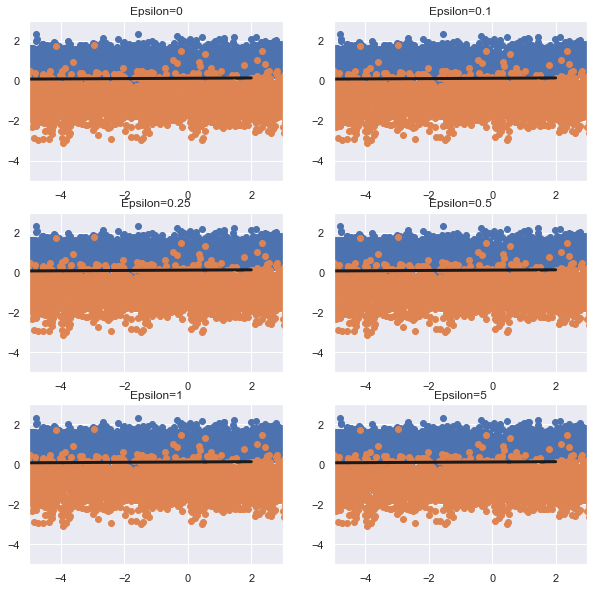

In [10]:
candidate_keys = {0: True} # First feature is candidate key 

epsilons = [0, 0.1, 0.25, 0.5, 1, 5]

fig, axs = plt.subplots(3,2, figsize=(10,10))
axs = axs.ravel()

for index, eps in enumerate(epsilons): 
    setup_and_generate(X, n, eps=0.1, preset_keys=candidate_keys) 
    X_synth = pd.read_csv('../data/synth.csv').to_numpy()
    plot_clf_data(X_synth, axs[index]) 
    lims = (int(np.rint(np.min(X))), int(np.rint(np.max(X))))
    z = range(lims[0], lims[1])
    axs[index].plot(z, regr_line(X_synth[:,:d],X_synth[:,d],z), 'k', 
                    linewidth=3)
    axs[index].set_title('Epsilon={0}'.format(eps))
    axs[index].set_ylim(lims)
    axs[index].set_xlim(lims)


## Pause to see how this works on real data 

In [7]:
hospital_data = 'data/hospital.csv'

datatypes = {
    'Time in A&E (mins)': 'Integer',
    'Treatment': 'String',
    'Gender': 'String',
    'Index of Multiple Deprivation Decile': 'Integer',
    'Hospital ID': 'String',
    'Arrival Date': 'String',
    'Arrival hour range': 'String',  
    'Age bracket': 'String'
}

categories = {
    'Hospital ID': True,
    'Time in A&E (mins)': False,
    'Treatment': True,
    'Gender': True,
    'Index of Multiple Deprivation Decile': False,
    'Arrival Date': True,
    'Arrival hour range': True,  
    'Age bracket': True
}


create_synth_data(hospital_data, description_path='../data/hospital_description.csv', 
                  eps=0.1, n=10000, out_path='../data/hospital_synthetic.csv', datatypes=datatypes, 
                 categories=categories, opt=True)

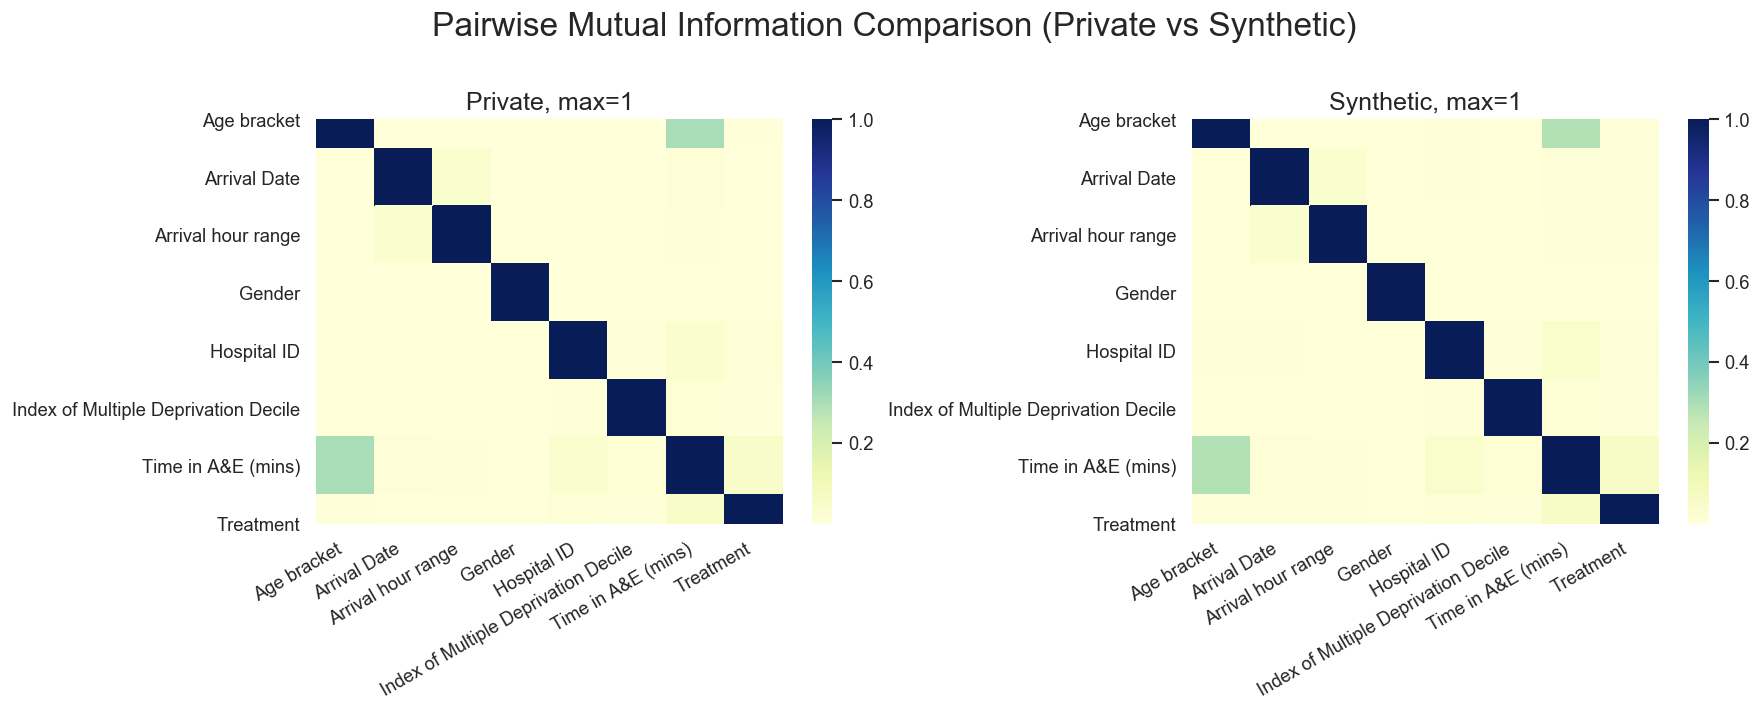

In [8]:
hospital_df = pd.read_csv(hospital_data)
synth_hospital_df = pd.read_csv('../data/hospital_synthetic.csv')

attribute_description = read_json_file('../data/hospital_description.csv')['attribute_description']
inspector = ModelInspector(hospital_df, synth_hospital_df, attribute_description)
inspector.mutual_information_heatmap()


### How does $\epsilon$ affect accuracy?

We'll run logistic regression on synthetically generated data with varying values of $\epsilon$, 
and then score the model against the true data. 
We do this for both the DataSynthesis package and IBM's differential privacy package, and compare the results. 

Start with seed data using sklearn's make_classification. 

In [18]:
def acc_experiment(X, seed_data, out_path, desc, epsilons, iters=1, fake=True, m=len(X)):
    """
    Run epsilon vs accuracy experiment on DataSynthesis Package vs 
    IBM Differential Privacy package 
    
    :param fake: == True iff X is randomly generated fake data. Otherwise set fake = False. 
    :param m: amount of synthetic data to generate 
    """

    accuracies, dp_accuracies = [], []
    
    if fake: 
        datatypes, categories, cand_keys = synth_setup(X, seed_data)
    else: 
        datatypes, categories, cand_keys = None, None, None 

    for eps in tqdm(epsilons): 
        score, dp_score = 0, 0
        for _ in range(iters): 
            rand_indices = np.random.choice(len(X), min(len(X), 2000), replace=False)

            create_synth_data(seed_data, eps=eps, n=len(X), description_path=desc, out_path=out_path, 
                             datatypes=datatypes, candidate_keys=cand_keys, categories=categories)

            Xy_synth = pd.read_csv(out_path).to_numpy()

            # Use synthetic data to train a classifier, test accuracy 
            lr = LogisticRegression(solver='lbfgs', multi_class='auto') 
            lr.fit(Xy_synth[:,:-1], Xy_synth[:,-1]) 
            score += lr.score(X[rand_indices,:-1], X[rand_indices,-1]) 

            # Compare with accuracy from IBM data
            create_synth_data(seed_data, eps=0, n=len(X), description_path=desc, out_path=out_path, 
                     datatypes=datatypes, candidate_keys=cand_keys, categories=categories)

            Xy_synth = pd.read_csv(out_path).to_numpy()

            dp_lr = dp.LogisticRegression(epsilon=eps, data_norm=2)
            dp_lr.fit(Xy_synth[:,:-1], Xy_synth[:,-1])
            dp_score += dp_lr.score(X[rand_indices,:-1], X[rand_indices,-1])

        accuracies += [ score / iters ]    
        dp_accuracies += [ dp_score / iters ]
        
    return accuracies, dp_accuracies 


def plot_accuracies(epsilons, accuracies, dp_accuracies, saveas='accuracy vs epsilon.png'):
    """Plot epsilon vs accuracy for DataSynthesis and IBM packages"""
    plt.plot(epsilons, accuracies, 'o', label='DataSynthesis')
    plt.plot(epsilons, dp_accuracies, 'ro', label='IBM')
    plt.xlabel('epsilon')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('../output/' + saveas)
    

In [2]:
n, d = 5000, 10
iters = 4 # Average iters answers 
X = gen_seed_data(n, d, scale=0.1)
seed_data = 'data/seed.csv'
out_path = 'data/synth.csv'
desc = 'data/desc.csv'

accuracies, dp_accuracies = [], []
epsilons = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]

datatypes, categories, cand_keys = synth_setup(X, seed_data)

for eps in epsilons: 
    score, dp_score = 0, 0
    for _ in range(iters): 
        rand_indices = np.random.choice(n, 1000, replace=False)
        
        create_synth_data(seed_data, eps=eps, n=n, description_path=desc, out_path=out_path, 
                         datatypes=datatypes, candidate_keys=cand_keys, categories=categories)

        Xy_synth = pd.read_csv(out_path).to_numpy()

        # Use synthetic data to train a classifier, test accuracy 
        lr = LogisticRegression(solver='lbfgs', multi_class='auto') 
        lr.fit(Xy_synth[:,:-1], Xy_synth[:,-1]) 
        score += lr.score(X[rand_indices,:-1], X[rand_indices,-1]) 
        
        # Compare with accuracy from IBM data
        create_synth_data(seed_data, eps=0, n=n, description_path=desc, out_path=out_path, 
                 datatypes=datatypes, candidate_keys=cand_keys, categories=categories)

        Xy_synth = pd.read_csv(out_path).to_numpy()

        dp_lr = dp.LogisticRegression(epsilon=eps, data_norm=2)
        dp_lr.fit(Xy_synth[:,:-1], Xy_synth[:,-1])
        dp_score += dp_lr.score(X[rand_indices,:-1], X[rand_indices,-1])
    
    accuracies += [ score / iters ]    
    dp_accuracies += [ dp_score / iters ]





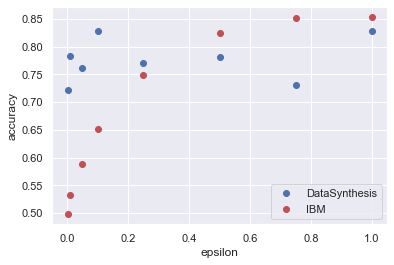

In [4]:
plt.plot(epsilons, accuracies, 'o', label='DataSynthesis')
plt.plot(epsilons, dp_accuracies, 'ro', label='IBM')
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('output/accuracy vs epsilon.png')

Now use data which is normally distributed (using sklearn's make_blobs)

In [17]:
n, d = 5000, 10
X = gen_seed_data(n, d, scale=0.05, gauss=True)
seed_data = 'data/seed.csv'
out_path = 'data/synth.csv'
desc = 'data/desc.csv'

epsilons = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]

accuracies, dp_accuracies = acc_experiment(X, seed_data, out_path, desc, epsilons, iters=4)





100%|██████████| 8/8 [24:43<00:00, 185.47s/it]


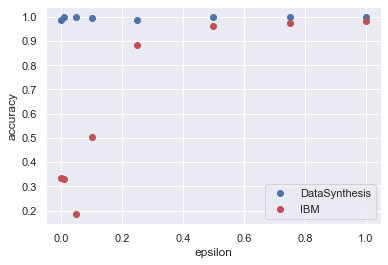

In [19]:
plot_accuracies(epsilons, accuracies, dp_accuracies, saveas='epsilon_vs_accuracy_gauss.png')

## Tests on a real dataset

In [20]:
X = pd.read_csv('data/data_banknote_authentication.txt').to_numpy()

# scale the data so that the 2-norm is smaller than 2 (required by DataSynthesis package)
# X[:,:-1] *= 0.01

seed_data = 'data/data_banknote_authentication.txt'
out_path = 'data/bank_synth.csv'
desc = 'data/bank_synth.csv'

epsilons = [0.01, 0.01, 0.1, 0.25, 0.5, 0.6, 0.75, 0.9, 1]

accuracies, dp_accuracies = acc_experiment(X, seed_data, out_path, desc, epsilons, fake=False, iters=4)







  0%|          | 0/9 [00:00<?, ?it/s]/Users/benchugg/Documents/projects/irs-active-learning/lib/python3.7/site-packages/diffprivlib/models/logistic_regression.py:220: PrivacyLeakWarning: Differential privacy is only guaranteed for data whose rows have a 2-norm of at most 2. Got 22.850350
Translate and/or scale the data accordingly to ensure differential privacy is achieved.
  % (self.data_norm, max_norm), PrivacyLeakWarning)
/Users/benchugg/Documents/projects/irs-active-learning/lib/python3.7/site-packages/diffprivlib/models/logistic_regression.py:220: PrivacyLeakWarning: Differential privacy is only guaranteed for data whose rows have a 2-norm of at most 2. Got 22.850350
Translate and/or scale the data accordingly to ensure differential privacy is achieved.
  % (self.data_norm, max_norm), PrivacyLeakWarning)
/Users/benchugg/Documents/projects/irs-active-learning/lib/python3.7/site-packages/diffprivlib/models/logistic_regression.py:220: PrivacyLeakWarning: Differential privacy is on

/Users/benchugg/Documents/projects/irs-active-learning/lib/python3.7/site-packages/diffprivlib/models/logistic_regression.py:220: PrivacyLeakWarning: Differential privacy is only guaranteed for data whose rows have a 2-norm of at most 2. Got 22.850350
Translate and/or scale the data accordingly to ensure differential privacy is achieved.
  % (self.data_norm, max_norm), PrivacyLeakWarning)
/Users/benchugg/Documents/projects/irs-active-learning/lib/python3.7/site-packages/diffprivlib/models/logistic_regression.py:220: PrivacyLeakWarning: Differential privacy is only guaranteed for data whose rows have a 2-norm of at most 2. Got 22.850350
Translate and/or scale the data accordingly to ensure differential privacy is achieved.
  % (self.data_norm, max_norm), PrivacyLeakWarning)
/Users/benchugg/Documents/projects/irs-active-learning/lib/python3.7/site-packages/diffprivlib/models/logistic_regression.py:220: PrivacyLeakWarning: Differential privacy is only guaranteed for data whose rows have a

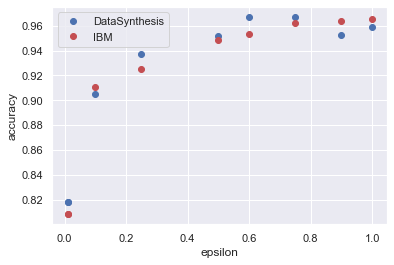

In [22]:
plot_accuracies(epsilons, accuracies, dp_accuracies, saveas='epsilon vs accuracy_banknote.png')

## Time vs number of features 

In [26]:
n = 1000
num_features = range(5, 50, 10)

seed_data = 'data/seed.csv'
out_path = 'data/out.csv'
desc = 'data/description.csv'

times = []

for d in num_features: 
    
    # Generate seed data
    X = gen_seed_data(n, d)
    
    start = time.time()
    # Generate synthetic data 
    datatypes, categories, cand_keys = synth_setup(X, seed_data) 

    create_synth_data(seed_data, description_path=desc, 
                  eps=0.1, n=n, out_path=out_path, datatypes=datatypes, 
                 categories=categories, candidate_keys=cand_keys, opt=True)
    
    times += [time.time() - start]
    

Describing data...

     f2  f4  f5  f3  f6  f1
0    10  14   7   8   0  11
1    13  12  10   6   1  11
2     8   9  11  12   0   8
3     5   8  13  11   0  10
4    13   6  11  14   1  14
..   ..  ..  ..  ..  ..  ..
995  11  12   9   9   1  11
996   5   7   8  10   0  14
997   9  10  13   9   1  14
998  11   3  15   8   1  17
999   8   4  12  13   1  14

[1000 rows x 6 columns]
================ Constructing Bayesian Network (BN) ================
Adding ROOT f3
Adding attribute f6
Adding attribute f1
Adding attribute f2
Adding attribute f5
Adding attribute f4
========================== BN constructed ==========================
Generating data, n = 1000 

Describing data...

     f2  f8  f7  f3  f10  f1  f15  f11  f14  f13  f9  f16  f4  f5  f6  f12
0    19   9   8  10   10   9   11   10    9    9   9    0  10  14   7    5
1    18  10   9  14    5   6   19    9   13    6   0    0  13  15   9    9
2    12   8  10   9   12  11    4   10   11   13   8    0  11   7   9    2
3    11   5  10   

Adding attribute f37
Adding attribute f33
Adding attribute f30
Adding attribute f23
Adding attribute f20
Adding attribute f22
Adding attribute f12
Adding attribute f18
Adding attribute f35
Adding attribute f8
Adding attribute f38
Adding attribute f1
Adding attribute f21
Adding attribute f36
Adding attribute f32
Adding attribute f4
Adding attribute f45
Adding attribute f11
Adding attribute f28
Adding attribute f16
Adding attribute f15
Adding attribute f17
Adding attribute f41
Adding attribute f43
Adding attribute f13
Adding attribute f19
Adding attribute f46
Adding attribute f27
Adding attribute f40
Adding attribute f31
Adding attribute f2
Adding attribute f5
========================== BN constructed ==========================
Generating data, n = 1000 



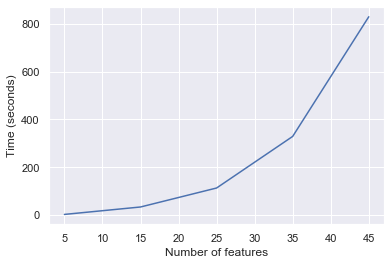

In [29]:
plt.plot(num_features, times)
plt.ylabel('Time (seconds)')
plt.xlabel('Number of features')
plt.show()

